# 23.02 Gradient Boosting 

Recall that you last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  It was said that for a particular regression model with $n$ parameters and $n+1$ dimensional space existed defined by all the parameters plus the cost/loss function to maximize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until you reach the lowest point on the surface, where all possible gradients are 'uphill'.  The final model is made up of the parameter estimates that define that location on the surface.  

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.

Gradient boosting can work on any combination of loss function and model type, as long as you can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however gradient boosting used decision trees, and minimizes either the residual (regression trees) or the negative log-likelihood (classification trees).

### Gradient Boosting With Regression Trees 

The loss function to minimize is the sum of the squared residuals: 

$$\frac{1}{n}\sum^n_{i=1}(y_i-(\alpha+\beta x_i))^2$$

(Though is can also be the sum of the absolute value of the residuals, as in lasso regression.)

Each time you run a decision tree; you extract the residuals.  Then you run a new decision tree, using those residuals as the outcome to be predicted.  After reaching the stopping point, you add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

The decision trees you use can be very simple.  In the example below, the decision only have a max depth of 2, meaning a maximum of four leaves.  These weak learners do not have to perform well as all individually in order to do well in aggregate.

Here you're going to do gradient boosting with regression tress by hand.  Your goal is to predict the variable "happy" using all the other variables in the European Social Survey dataset.  You'll calculate a tree, store the predicted values, pull the residuals, and run a new tree on the residuals.  This will repeat 101 times.  At the end, you add together all the predicted values from each iteration to yield the final prediction.

In [1]:
import scipy
import pydotplus 
import graphviz

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import tree 
from IPython.display import Image

In [4]:
# Working with the European Social Survey 
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
        "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

Weak learner 0 R^2: -21.86595826514709
Weak learner 20 R^2: -0.00261929230081992
Weak learner 40 R^2: -0.0016748172727343302
Weak learner 60 R^2: -0.0014818633549413818
Weak learner 80 R^2: -0.0012578370480087475
Weak learner 100 R^2: -0.0007136861925909344


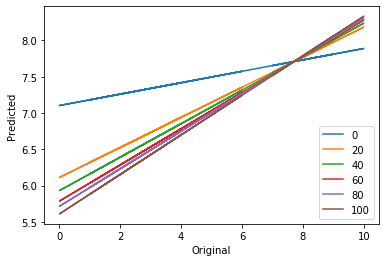

Overall R^2: 0.5282873581794292


In [6]:
# Define outcome and predictors
y = df["happy"]
X = df.loc[:, ~df.columns.isin(["happy","cntry"])]

# Make the categorical variable "country" into dummies.
X = pd.concat([X,pd.get_dummies(df["cntry"])], axis=1)

# Store values for loops 
preds = pd.DataFrame()
labels = list()

uniquex = df["happy"].unique()

# Iterate through decision trees, each time using the residuals from the previous tree as the inputs
for m in range(0,101):
    # Initialize and fit the tree.  Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)

    # Get and store the predicted values
    pred = decision_tree.predict(X)
    preds[f"pred{m}"]=pred

    # Residuals
    y = y - pred

    # Output every 20 iterations
    if m % 20 == 0:
        print(f"Weak learner {m} R^2: {decision_tree.score(X,y)}")
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df["happy"], bestpred, 1))(uniquex))

plt.legend(labels)
plt.xlabel("Original")
plt.ylabel("Predicted")
plt.show()
predicted = preds.sum(axis=1)

print("Overall R^2: ", end="")
print(np.corrcoef(df["happy"], predicted)[0,1])

Looking at the sampling of individual model $R^2$, these are certainly 'weak learners'.  They perform very badly indeed.  Yes, in the aggregate, the models are able to explain nearly 53% of the variance in "happiness" in the dataset.  This is a great example of the power of gradient boosting.  You may also not from the plot that the greatest gains happened in the earlies models, with subsequent steps yielding smaller gains in explanatory power.  

Now try it with a decision tree:

One strongish learner R^2: 0.21072567176527268


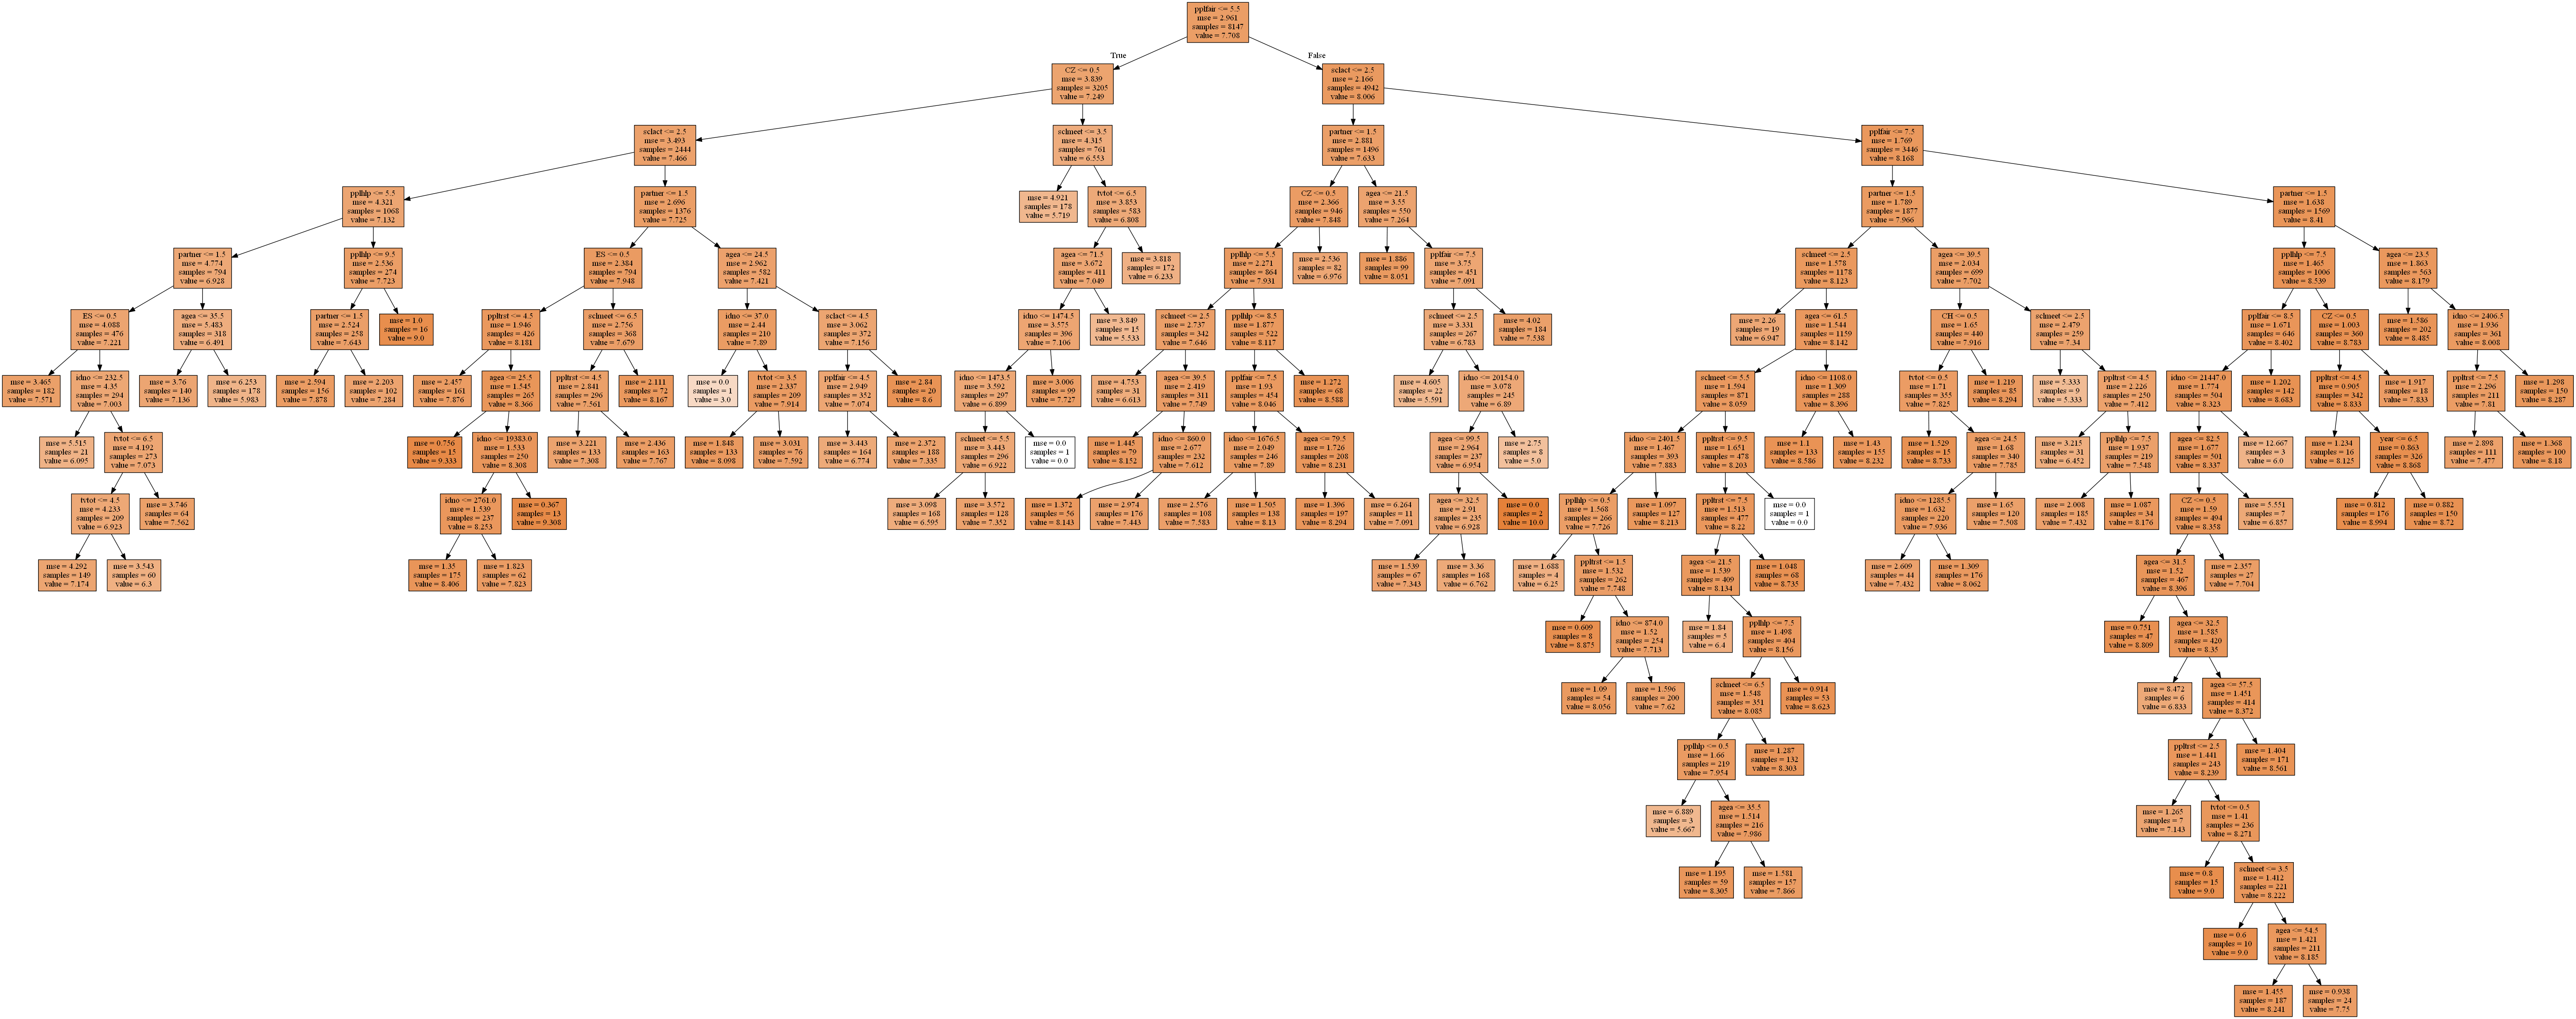

In [7]:
# One big tree.  Each node split will include at least 2.5% fo the total sample
decision_tree = tree.DecisionTreeRegressor(min_samples_split=0.025)
y = df["happy"]
decision_tree.fit(X,y)

# Get and store predicted values
pred = decision_tree.predict(X)
print(f"One strongish learner R^2: {decision_tree.score(X,y)}")

dot_data = tree.export_graphviz(decision_tree, out_file=None, 
    feature_names=X.columns, 
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

That didn't work at all.  Gradient boosting with weak learners was nearly twice as effective as one complex decision tree.  In fact, in many instances gradient boosted decision trees perform better than random forests.  They are also less prone to overfitting then individual decision trees.

### Overfitting 

Still it is easy to see that the more iterations you run, the more likely you are to overfit.  Gradient boost comes with some methods to avoid overfitting.  Cross-validation will check for overfitting, but there are also methods that can be applied before using the test set that will reduce the likelihood of overfit. 

One option is subsampling, where each iteration of the boost algorithm uses a subsample of the original data.  By introducing some randomness into the process, subsampling makes it harder to overfit.

Another option is shrinkage, which you have encountered before in ridge regression.  Here the shrinkage/regularization parameter, called the "learning rate", causing each "step" along the loss function gradient to be a little smaller than the previous one.  This prevents any one iteration from being too influential and misdirecting the overall boost solution.  Learning rates vary between 0 (only the initial iteration matters) to 1 (all iterations are weighted equally).  A model made up of many small steps is less prone to overfitting than a model made up of a few large steps, but it can also lead to much slower running times, depending on the stopping rule in play.

In the next notebook, you'll try gradient boosting using the SKLearn package, which comes with all sorts of helpful features for getting the most out of gradient boost.
